# This is a Man's word

## Project setup

Mouting the Google Drive

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing dependencies

In [121]:
# Toggle in order to install dependencies as you run the notebook
INSTALL_DEPS = False

In [122]:
if INSTALL_DEPS:
  !pip install nltk gensim spacy
  !pip install empath
  !python -m spacy download en
  !python -m nltk.downloader punkt
  !python -m nltk.downloader all-corpora
  !pip install fastparquet
  !pip install toolz

In [123]:
if INSTALL_DEPS:
  !pip install pyLDAvis
  !pip install "openpyxl>=3.0"
  !pip3 install pickle5
  !pip install -Uqq ipdb

In [124]:
%pdb off

Automatic pdb calling has been turned OFF


### Importing libraries

In [125]:
import pandas as pd
import bz2
import json
import string
import re
import matplotlib.pyplot as plt
import requests
import nltk
import gc
import ipdb
import os
from math import ceil
import numpy as np

import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from functools import partial
from toolz import compose
from itertools import product
import pickle5 as pickle

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

In [126]:
if INSTALL_DEPS:
  nltk.download('punkt')
  nltk.download('wordnet')
  nltk.download('stopwords')
  nltk.download('averaged_perceptron_tagger')

We disable the warnings - in general it's a bad practice and should be avoided in any longer-maintained project. Nonetheless, while training the model we get a warning about a deprecated function in one of the dependencies - it's prints the message thousands of times and thus slows down the training phase and affects readability.

In [127]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Loading dataset

In [128]:
def get_path_to_file(year):
  return f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2'

def load_speaker_attrs():
  return pd.read_parquet("/content/drive/MyDrive/Project datasets/speaker_attributes.parquet")

def load_attrs_labels():
  return pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

def get_wikidata_uri(q):
  return f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={q}&languages=en&format=json"

## Processing speaker attributes

### Resolving Q-codes


TODO: nice description

In [129]:
def resolve_q_code(labels, q):
  '''Returns label of the QCODE if found.'''
  try:
    return labels.loc[q]['Label']
  except KeyError:
    return None

def untangle_codes(codes, labels):
  discard_none = lambda xs: filter(lambda x: x is not None, xs)
  resolve_code = partial(resolve_q_code, labels)
  return compose(
    list,
    discard_none,
    partial(map, resolve_code)
  )(codes)

def interpolate_q_codes_new_way(df, labels, columns):
  '''Adds labeled features to the df.'''
  for col in columns:
    df[col] = df[col].apply(lambda codes: untangle_codes(codes, labels) if codes is not None else None)

We want to associate the quote's speaker with an entry in speaker attributes dataframe. However, as in the Quotebank aliases might have been used, we construct an **Alias Name -> Index in Speaker attrs** mapping.

This mapping is then left-joined with quote's speaker and with speaker attrs so that we can have full speaker metadata for a quote.

In [130]:
def construct_speaker_names(speaker_attrs):
  """Associates the speaker attributes index with all speaker aliases"""
  
  speaker_names = speaker_attrs.aliases.explode().append(speaker_attrs.label)
  speaker_names = speaker_names.drop(speaker_names[speaker_names.isna()].index)

  speaker_names_df = pd.DataFrame({"speaker": speaker_names, "speaker_attr_idx": speaker_names.index})
  speaker_names_df = speaker_names_df.set_index('speaker')
  return speaker_names_df


def clean_speaker_attrs(speaker_attrs):
  return speaker_attrs[['nationality', 'gender', 'occupation', 'label']].copy()

In [131]:
# If more columns with q-codes need to be resolved they should be added here
Q_CODES_COLUMNS = ['nationality', 'occupation', 'gender']


def process_speaker_attrs():
  speaker_attrs = load_speaker_attrs()
  attrs_labels = load_attrs_labels()

  interpolate_q_codes_new_way(speaker_attrs, attrs_labels, Q_CODES_COLUMNS)
  speaker_names_df = construct_speaker_names(speaker_attrs)
  trimmed_speaker_attrs = clean_speaker_attrs(speaker_attrs)

  return trimmed_speaker_attrs, speaker_names_df

**Run speaker attributes processing**

Processing speaker attrs due to its size takes time - we have run
it once and saved the results to pickle so that it can be loaded fast


In [132]:
# Toggle to 1 if you want to re-proces attrs (most likley you don't want to)
REPROCESS_SPEAKER_ATTRS = False

if REPROCESS_SPEAKER_ATTRS:
  speaker_attrs, speaker_names_df = process_speaker_attrs()
  speaker_attrs.to_pickle("/content/drive/MyDrive/ADA/speaker_attrs__no_aliases.pkl")
  speaker_names_df.to_pickle("/content/drive/MyDrive/ADA/speaker_names_df.pkl")

**Load cached processed speaker attributes**

In [133]:
# Toggle to 1 if you need speaker attributes in your further processing
# Note that later we merge it with quotes dataset so most likley it's not necessary
LOAD_SPEAKER_ATTRS = False

if LOAD_SPEAKER_ATTRS:
  speaker_attrs = pd.read_pickle("/content/drive/MyDrive/ADA/speaker_attrs__no_aliases.pkl")
  speaker_names_df = pd.read_pickle("/content/drive/MyDrive/ADA/speaker_names_df.pkl")

## Loading Human Development Index

We download now the Human Development Index dataset (HDI). The first nationality mentioned in the dataset for a given speaker is the one that we will match with the corresponding HDI score. HDI is represented as a number from 0 to 1, but we narrow down ourselves to four categories of developemnt:

1. Very High
1. High
1. Medium
1. Low

with ranges defined by United Nations.

In [134]:
def load_HDI():
  return pd.read_excel('/content/drive/MyDrive/ADA/HDI_list.xlsx')


def merge_HDI_with_chunk(chunk_df):
  '''Merges HDI score with speaker's first nationality'''

  chunk_df['N'] = [next(iter(nationality), ' ') for nationality in chunk_df['nationality']]
  chunk_df = pd.merge(chunk_df, HDI, on='N') 
  return chunk_df


def merge_speaker_attrs_with_chunk(chunk_df):
  '''Merges speakers attributes data based on speaker column'''  
  chunk_df = chunk_df.join(speaker_names_df, on='speaker')

  # discard quotes for which the speaker could not be found
  chunk_df = chunk_df.drop(chunk_df[chunk_df.speaker_attr_idx.isna()].index)
  return chunk_df.join(speaker_attrs, on='speaker_attr_idx')

In [135]:
HDI = load_HDI()

##  Classifying occupations

After looking at the 500 most common occupations, we manually created "buckets" ressembling similar jobs into 5 main categories:

1.   Sports: it regroups athletes and people involved in the management/organization of teams: e.g football player, association football manager, swimmer, rower, race car driver...
2.   Media: e.g journalist, television presenter, fashion model, influencer, web developer...

3.   Economy_politics: it includes in fact 3 subcategories, people involved in the world of business (e.g economist, investment banker, business executive...), politics or state responsabilities (governor, deputy, minister...) or military service (military officer, military leader..).

4.   Arts: e.g actor, writer, singer, rock musician, painter...

5.   Academics: including scientists specialized in different fields and personnel in the healthcare domain (e. g data scientist, engineer, veterinarian...)

We chose these categories as they include supposed men-dominant professions, for example in the fields of sports and politics, but also some thought to be more equally represented such as in the domains of academics or arts. This at least, represents a stereotype that we will test with further analyses.

In the following steps, we will classify as 'Other' all those rows whose speaker's profession does not fall into one of our categories. In the case of speakers with multiple occupations, each of them will be classified as mentioned above. 

In [136]:
def load_jobs_types():
  JOBS_TYPES = ["sports", "media", "important_people", "art", "academics"]
  jobs = {}

  for job_type in JOBS_TYPES:
    with open(f"/content/drive/MyDrive/ADA/jobs_{job_type}.txt", 'r') as f:
        text = [line for line in f.read().split('\n')]
    jobs[job_type] = list(filter(bool, text))

  return jobs


def embed_occupation_class(chunk_df):
  job_types = load_jobs_types()

  class_occupation = []
  for val in chunk_df.occupation:
    person_occ = set()
    for occ in val:
      for job_type, jobs in job_types.items():
        if occ in jobs:
          person_occ |= {job_type}
          break
      else:
        person_occ |= {"Other"}

    class_occupation.append(list(person_occ))

  chunk_df["Class_Occup"] = pd.Series(class_occupation)
  return chunk_df


def clean_occupation(chunk_df):
  '''Drops rows with missing occupation.'''
  discard_na(chunk_df, 'occupation')
  return chunk_df


def save_most_common_jobs(df):
    occ = df['occupation'].explode()
    jobs = list(dict(Counter(occ).most_common(700)).keys())

    with open("/content/drive/MyDrive/ADA/jobs.txt", "w") as f:
      for job in jobs:
        if job is not None:
          f.write(job + "\n")

## Data cleaning

### Quotation cleaning

As the quotations will be the focus of a significant part of our further analysis, we designed the following pipeline to preprocess them: 

1) First the quotes are lower-cased and punctuation marks and extra white spaces are removed. 

2) Then, each quote is tokenized into chunks or words. 

3) We train a model imported from the Gensim library to find bigrams among the tokenized quotes. Bigrams are couples of words that often co-occur in given contexts: e.g CT scan, Prime Minister, United States etc. We would like to find only those pairs of words that form a meaningful bigram. In order to do so, we first need to introduce the notion of Pointwise Mutual Information (PMI) score (write equation here). This measure indicates how much more likely the two words co-occur than if they were independent. However, this method is very sensitive to rare combinations of words: for example, if 'abc def' appear once together as a bigram, but 'abc' and 'def' individually are not present in the text, this will result in a high PMI score for the bigram 'abc def'. In order to overcome this limitation, we will combine this method with a frequency filter to retain only those bigrams that appear with a frequency higher than an arbitrary threshold decided by us.









In [137]:
ps = PorterStemmer()
lem = WordNetLemmatizer()

IGNORED_KEYWORDS_FOR_TOPICS = ['there', "little_bit", "got_ta", "wan_na", "gon_na", 'people', 'time', 'like', 'one', 'get', 'think', 'going', 'would', 'want', 'dont', 'need', 'know', 'really', 'good', 'thing', 'make', 'well', 'way', 'see', 'day', 'work', 'thats', 'lot', 'come', 'got', 'game', 'back', 'right', 'take', 'also', 'new', 'many', 'first', 'much', 'great', 'could', 'say', 'every', 'always', 'best', 'look', 'even', 'something', 'last', 'two', 'ive', 'still', 'important', 'keep', 'put', 'part', 'today', 'made', 'give', 'there', 'around', 'said', 'week', 'together', 'big', 'place', 'didnt', 'done', 'able', 'cant', 'working', 'sure', 'different', 'next', 'everyone', 'bit', 'change', 'little', 'end', 'youre', 'must', 'continue', 'long' , 'hard', 'everything', 'let', 'may', 'situation', 'point', 'getting', 'coming', 'theyre', 'three', 'thought', 'forward', 'kind', 'moment', 'away', 'looking', 'trying', 'stay', 'try', 'month', 'another', 'possible', 'believe', 'without', 'making', 'wanted', 'came', 'difficult', 'find', 'doesnt', 'anything', 'use', 'ever', 'person', 'problem', 'child', 'already', 'across', 'since', 'real', 'challenge', 'ensure', 'step', 'plan', 'might', 'experience', 'enough', 'seen', 'someone', 'actually', 'probably', 'far', 'tell', 'hand', 'matter', 'happen', 'whole', 'understand', 'quite', 'used', 'chance', 'clear', 'went', 'talk', 'bring', 'taking', 'whether', 'result', 'taken', 'given', 'started', 'open', 'obviously', 'feel', 'better', 'never', 'weve', 'show', 'guy', 'happy', 'start', 'decision', 'mean', 'young', 'strong', 'nothing', 'run', 'high', 'fact', 'become', 'four', 'wasnt', 'move', 'five', 'maybe', 'told', 'ready', 'happened', 'left', 'tough', 'saying', 'especially', 'knew', 'thank', 'took', 'anyone', 'huge', 'wont', 'yet', 'within', 'else', 'saw', 'sometimes', 'definitely', 'needed', 'name', 'talking', 'playing', 'play', 'played', 'pretty', 'second', 'group', 'call', 'question', 'reason', 'bad', 'amazing', 'nice', 'easy', 'including', 'shes', 'youve', 'havent', 'couldnt', 'absolutely', 'whatever', 'gave', 'towards', 'true', 'whats', 'gone', 'certainly', 'theyve', 'almost', 'yes', 'wouldnt', 'isnt', 'though', 'seeing', 'rather', 'giving', 'however', 'along', 'often', 'certain', 'completely', 'either', 'available', 'particularly', 'standard', 'successful', 'extremely', 'common', 'among', 'somebody', 'yeah', 'instead', 'ago', 'were', 'arent']
part_of_speech_to_discard = ['IN', 'DT', 'CC', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS', 'POS', 'PRP', 'PRP']


def normalize_quote(s:str) -> str:
    """
    Lower text, remove punctuation and extra whitespace.
    """
    
    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_punc(lower(s)))


def tokenize_words(series):
    return series.apply(compose(nltk.tokenize.word_tokenize, normalize_quote))


def train_bigrams_model(tokenized_words):
  bigram = gensim.models.Phrases(tokenized_words, min_count=10, threshold=100)
  return gensim.models.phrases.Phraser(bigram)


def embed_bigrams(tokenized_words):
  bigram_model = train_bigrams_model(tokenized_words)
  return tokenized_words.apply(lambda x: bigram_model[x])


def filter_useless_speach_parts(words):
  # reference: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
  return [
    word for word, tag in nltk.pos_tag(words)
    if str(tag) not in part_of_speech_to_discard
  ]


def extract_keywords(tokenized_words):
  """
  - Tokenize text
  - Excluded stop words
  - Lemmatized resulting keywords
  """

  stopwords = nltk.corpus.stopwords.words('english')
  filtered_words = filter_useless_speach_parts(tokenized_words)

  return [
    lem.lemmatize(word)
    for word in filtered_words
    if word not in stopwords
       and len(lem.lemmatize(word)) > 2
       and word not in IGNORED_KEYWORDS_FOR_TOPICS
       and lem.lemmatize(word) not in IGNORED_KEYWORDS_FOR_TOPICS
  ]


def drop_empty_keywords(chunk_df):
  AT_LEAST_KEYWORDS = 2
  return chunk_df[chunk_df.keywords.apply(
      lambda x: x if len(x) >= AT_LEAST_KEYWORDS else None
  ).notna()]


### Clean features

The next step is the data cleaning: we discard from the dataset those quotes with missing attributed speaker, gender, nationality or occupation. 


In [138]:
def discard_na(df, col):
  '''Drops rows with col value equal to None.'''
  df[col].replace('None', pd.NA, inplace=True)
  df.drop(df[df[col].isna() == True].index, inplace=True)


def clean_speaker(chunk_df):
  discard_na(chunk_df, 'speaker')
  return chunk_df


def clean_gender(chunk_df):
  '''Drops rows with missing gender.'''
  clean = lambda x: x[0] if x is not None and x[0] in ["male", "female"] else None
  chunk_df['gender'] = chunk_df['gender'].apply(clean)
  discard_na(chunk_df, 'gender')
  return chunk_df


def clean_nationality(chunk_df):
  '''Drops rows with missing nationality.'''
  _discard_na(chunk_df, 'nationality')
  return chunk_df


def drop_nonfrequent_quotes(chunk_df):
  return chunk_df[chunk_df["numOccurrences"] > 1]


def drop_uncertain_speakers(chunk_df):
  return chunk_df[chunk_df.probas.apply(lambda x: x[0][1]).astype(float) > 0.6]

### Preprocess chunks

All the previous preprocessing and cleaning operations are called into the following function to process each chunk.


In [139]:
COLUMNS_OF_INTEREST = [
  'numOccurrences', 'gender', 'occupation',
  'nationality', 'keywords', 'Class_Occup',
  'HDI rank', 'Development', 
]

def preprocess_chunk(chunk_df):
  '''
  Apply basic preprocessing and data cleaning to a chunk
  - Merge the chunk with the speaker attributes and HDI indexes
  - Remove rows with missing speakers, nationalities, genders and occupations
  - Process features in a format more appropriate for our use case
  '''
  chunk_df = compose(
    embed_occupation_class,
    merge_HDI_with_chunk,
    clean_occupation,
    clean_gender,
    clean_nationality,
    merge_speaker_attrs_with_chunk,
    clean_speaker,
    drop_uncertain_speakers,
    drop_nonfrequent_quotes,
  )(chunk_df)

  chunk_df['keywords'] = pd.Series(compose(
      lambda s: s.apply(extract_keywords),
      embed_bigrams,
      tokenize_words,
  )(chunk_df.quotation))

  chunk_df = drop_empty_keywords(chunk_df)

  chunk_df.rename({"N": "nationality", "HDI rank": "HDI_rank"}, inplace=True)
  chunk_df = chunk_df[COLUMNS_OF_INTEREST]
  return chunk_df

We extract a given number of chunks of specified size from the Quotebank file corresponding to a certain year. Then we process the chunk and calculate the distributions.

In [140]:
from datetime import datetime


def iterate_chunks(year, chunk_size, num_of_chunks):
  '''Extracts a number of chunks from the file corresponding to the specified year.'''

  with bz2.open(get_path_to_file(year), 'rb') as file:
    lines = []

    for i, line in enumerate(file):
      lines.append(json.loads(line))

      if i % chunk_size == 0 and i != 0:
        yield pd.DataFrame(lines)
        del lines[:]
        lines = []

        if i / chunk_size == num_of_chunks:
           return

    yield pd.DataFrame(lines)
    del lines[:]


def preprocess_chunks_in_year(year, chunk_size = 100_000, num_of_chunks=10):
  for i, chunk_df in enumerate(iterate_chunks(year, chunk_size, num_of_chunks)):
      print(f"[{datetime.now()}] Pre-processing chunk {i+1} out of {num_of_chunks}")

      processed_chunk_df = preprocess_chunk(chunk_df)
      yield processed_chunk_df
      gc.collect()


def preprocess_and_cache_chunks(year):
  """
  Run preprocessing and cache intermediate results in the pickle format
  """
  for i, processed_chunk in enumerate(preprocess_chunks_in_year(year, chunk_size=500_000, num_of_chunks=100)):
    processed_chunk.to_pickle(f'/content/drive/MyDrive/ADA/chunk_{year}_{i}.pkl')
  return i


def concatenate_preprocessed_chunks(year, chunks_count=6):
  get_filename = lambda i: f'/content/drive/MyDrive/ADA/chunk_{year}_{i}.pkl'
  chunks = [pd.read_pickle(get_filename(i)) for i in range(chunks_count)]
  df = pd.concat(chunks)
  df = df.reset_index()
  df.to_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes_{year}.pkl')

  for i in range(chunks_count):
    os.remove(get_filename(i))

  return df


def read_preprocessed_from_year(year):
  return pd.read_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes_{year}.pkl')


def concatenate_data_across_years(years):
  years_dfs = []

  for year in years:
    df = read_preprocessed_from_year(year)
    df['year'] = year
    years_dfs.append(df)

  df = pd.concat(years_dfs)
  df = df.reset_index()
  df = df.drop(columns='index')
  df.to_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes.pkl')
  return df


def read_preprocessed_data():
    return pd.read_pickle(f'/content/drive/MyDrive/ADA/preprocessed_quotes.pkl')

### Run and cache

In [141]:
YEARS = [2015, 2016, 2017, 2018, 2019, 2020]


TEST_PROCESS_CHUNK = False

In [142]:
chunk_df = next(iterate_chunks(2020, 10_000, 1))
chunk_df

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,[],2020-02-15 14:12:51,2,"[[None, 0.581], [Andy Harris, 0.4191]]",[https://patriotpost.us/opinion/68622-trump-bu...,E
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,[Q20684375],2020-01-24 20:37:09,4,"[[Meghan King Edmonds, 0.5446], [None, 0.2705]...",[https://people.com/parents/meghan-king-edmond...,E
...,...,...,...,...,...,...,...,...,...
9996,2020-04-14-074488,Why should a running back be treated less than...,Mark Ingram,[Q452154],2020-04-14 22:03:37,1,"[[Mark Ingram, 0.5275], [None, 0.4657], [Chris...",[http://registercitizen.com/sports/article/Ing...,E
9997,2020-04-15-078413,"Why would I leave here where I'm healthy, to t...",Pauline Pearce,[Q55076551],2020-04-15 10:10:33,1,"[[Pauline Pearce, 0.8222], [None, 0.1778]]",[https://www.bbc.co.uk/news/uk-england-london-...,E
9998,2020-01-18-055386,"Will he be back? And if so, will it be with th...",None,[],2020-01-18 05:30:00,1,"[[None, 0.8911], [Tom Brady, 0.0929], [Logan R...",[http://www.mywebtimes.com/2020/01/14/full-cou...,E
9999,2020-03-26-086246,will not be the first commissioner of an Ameri...,Adam Silver,[Q4679786],2020-03-26 22:20:01,1,"[[Adam Silver, 0.5877], [None, 0.3937], [Jay M...",[http://sportsbusinessdaily.com/Daily/Issues/2...,E


In [143]:
if TEST_PROCESS_CHUNK:
  processed_chunk_df = preprocess_chunk(chunk_df)
  processed_chunk_df

In [144]:
YEAR = 2018
PREPROCESS_YEAR = False

if PREPROCESS_YEAR:
  chunks_count = preprocess_and_cache_chunks(YEAR)
  gc.collect()
  concatenate_preprocessed_chunks(YEAR, chunks_count)

In [145]:
CONCATENATE_ALL = False

if CONCATENATE_ALL:
  df = concatenate_data_across_years(YEARS)

In [146]:
df = read_preprocessed_data()

## Graphs

### Distribution of quotations across countries

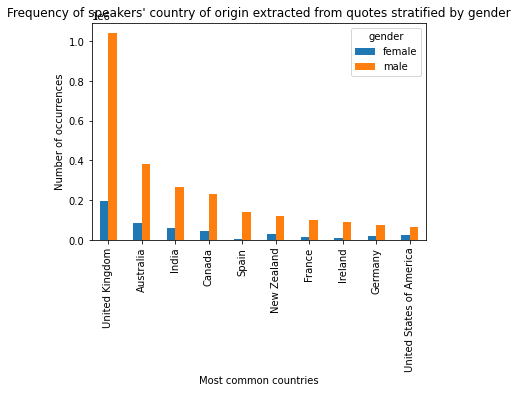

In [147]:
# TODO: most frequent nations left-to-right (lexicographic order now)
nationality_exploded = df.explode('nationality')
top_nations_list = nationality_exploded['nationality'].value_counts()[:10]
top_nations_df = nationality_exploded[nationality_exploded['nationality'].isin(top_nations_list.keys())]
top_nations = top_nations_df.groupby(['nationality', 'gender'])['nationality'].count().unstack('gender')
top_nations = top_nations.sort_values('male', ascending=False)

top_nations.plot(kind='bar')
plt.xlabel("Most common countries")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' country of origin extracted from quotes stratified by gender")

plt.show()

### Gender vs Development (TODO name sucks)

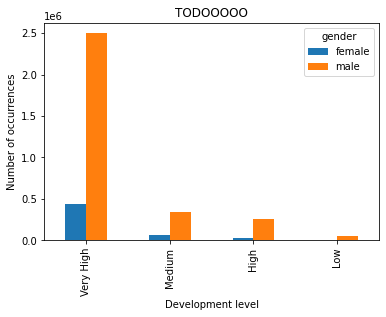

In [148]:
# TODO: make more interpretable; plot 4 pie plots side-by-side or smth else that is nice

hdi_gender_distribution = df.groupby(['Development','gender'])['Development'].count().unstack('gender')
hdi_gender_distribution = hdi_gender_distribution.sort_values('male', ascending=False)
hdi_gender_distribution.plot(kind='bar')

plt.xlabel("Development level")
plt.ylabel("Number of occurrences")
plt.title("TODOOOOO")

plt.show()

### Women vs occupations

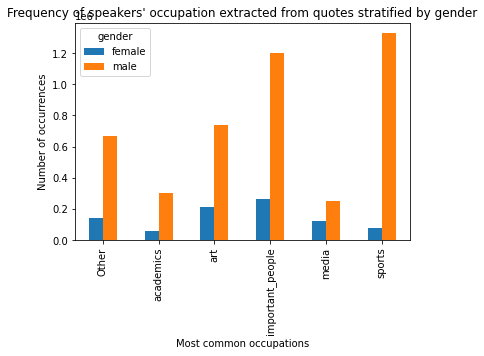

In [149]:
df_class_occ = df.explode("Class_Occup")
class_occup_distribution = df_class_occ.groupby(['Class_Occup','gender'])['Class_Occup'].count().unstack('gender')

class_occup_distribution.plot(kind='bar')

# TODO: labels
# TODO: add ratio of male vs female in each occ class
plt.xlabel("Most common occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupation extracted from quotes stratified by gender")

plt.show()

In [150]:
# TODO: the same as above but across development classes

## Topic Detection

### Preprocessing

We discard the most commonly occuring keywords which do not contribute towards better topic detection

In [151]:
def quotes_bags_of_words(keywords_series, max_freq=0.15, min_freq = 0.01):
  dictionary = Dictionary(keywords_series)
  min_wordcount = int(keywords_series.shape[0] * min_freq)

  dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
  bags_of_words = keywords_series.apply(dictionary.doc2bow)
  return {"bow": bags_of_words, "dict": dictionary}

### LDA Model

In [152]:
def train_topic_detection_model(keywords, hyperparams):
  corpus_data = quotes_bags_of_words(keywords, **hyperparams["bow"])
  corpus = corpus_data["bow"]
  dictionary = corpus_data["dict"]
  print(f"[{datetime.now()}] Training model with params: {hyperparams['model']}")
  return corpus, dictionary, LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    workers=6,
    **hyperparams["model"],
  )


def save_lda_model(lda_model, year="", num_topics=20):
  lda_model.save(f'/content/drive/MyDrive/ADA/lda_model_{year}__{num_topics}_topics')


def load_lda_model(year="", num_topics=20):
  return LdaMulticore.load(f'/content/drive/MyDrive/ADA/lda_model_{year}__{num_topics}_topics')


def compute_lda_coherence_score(lda_model, keywords, dictionary):
  coherence_model_lda = CoherenceModel(model=lda_model, texts=keywords, dictionary=dictionary, coherence='c_v')
  return coherence_model_lda.get_coherence()


def merge_topics_into_df(df, lda_model, num_topics):
  for j in range(num_topics): 
      df[f'topic_{j}'] = 0.0

  errors_count = 0
  for i in range(len(corpus)):
      bow = corpus[i]
      try:
          for j, x in lda_model[bow]:
              df[f'topic_{j}'].iat[i] = x
      except:
          errors_count += 1

  if errors_count:
    print("Erroneous rows: ", errors_count)


def get_human_readable_topics(model, num_topics, num_words=4):
  topics = model.show_topics(num_words=num_words, num_topics=num_topics, formatted=False)
  return [
    "__".join([word for word, _ in topic])
    for _, topic in topics
  ]


def topic_distribution(df, num_topics):
  return [df[f"topic_{i}"].apply(ceil).sum() for i in range(num_topics)]

### Hypertuning

In [159]:
from datetime import datetime

hypertune_params = {
  "bow": {
    "max_freq": 0.15,
    "min_freq": 0.0005,
  },
  "model": {
    "passes": 1,
    "iterations": 50,
    "random_state": 42,
    "chunksize": 4000,
  },
}

def hypertune_lda_model(train_keywords, hyper):
  topics = [5, 8, 10, 12, 13, 15, 16, 18, 20]
  alphas = list(np.arange(0.01, 0.4, 0.11))

  etas = list(np.arange(0.28, 1, 0.23)) + ['auto']

  best_topics_count = None
  max_coherence = 0

  for num_topics in topics:
    print(datetime.now())
    params = {
      "model": {**hyper["model"], "num_topics": num_topics},
      "bow": {**hyper["bow"]},
    }
    _, dictionary, model = train_topic_detection_model(train_keywords, params)
    coherence_score = compute_lda_coherence_score(model, train_keywords, dictionary)
    if coherence_score > max_coherence:
        best_topics_count = num_topics
        max_coherence = coherence_score
    yield {"alpha": "default", "eta": "default", "num_topics": num_topics, "coherence": coherence_score}

  for alpha, eta in product(alphas, etas):
    print(datetime.now())
    params = {
      "model": {**hyper["model"], "alpha": alpha, "eta": eta, "num_topics": best_topics_count},
      "bow": {**hyper["bow"]},
    }
    _, dictionary, model = train_topic_detection_model(train_keywords, params)
    coherence_score = compute_lda_coherence_score(model, train_keywords, dictionary)
    yield {"alpha": alpha, "eta": eta, "num_topics": best_topics_count, "coherence": coherence_score}

In [ ]:
RUN_HYPERTUNING = True

if RUN_HYPERTUNING:
  train_keywords = df.keywords.sample(frac = 0.0003)
  hypertuning_results = pd.DataFrame(hypertune_lda_model(train_keywords, hypertune_params))
  print("Done! ", datetime.now())
  hypertuning_results.to_pickle("/content/drive/MyDrive/ADA/model_hypertuning.pkl")

2021-12-11 21:18:47.332740
[2021-12-11 21:18:47.373938] Training model with params: {'passes': 1, 'iterations': 50, 'random_state': 42, 'chunksize': 4000, 'num_topics': 5}
2021-12-11 21:18:49.717857
[2021-12-11 21:18:49.751754] Training model with params: {'passes': 1, 'iterations': 50, 'random_state': 42, 'chunksize': 4000, 'num_topics': 8}
2021-12-11 21:18:52.050440
[2021-12-11 21:18:52.081021] Training model with params: {'passes': 1, 'iterations': 50, 'random_state': 42, 'chunksize': 4000, 'num_topics': 10}
2021-12-11 21:18:54.586859
[2021-12-11 21:18:54.617580] Training model with params: {'passes': 1, 'iterations': 50, 'random_state': 42, 'chunksize': 4000, 'num_topics': 12}
2021-12-11 21:18:57.124986
[2021-12-11 21:18:57.155951] Training model with params: {'passes': 1, 'iterations': 50, 'random_state': 42, 'chunksize': 4000, 'num_topics': 13}
2021-12-11 21:18:59.616308
[2021-12-11 21:18:59.646507] Training model with params: {'passes': 1, 'iterations': 50, 'random_state': 42, '

In [ ]:
LOAD_HYPERTUNING = False

if LOAD_HYPERTUNING:
  with open("/content/drive/MyDrive/ADA/model_hypertuning.pkl", "rb") as fh:
    hypertuning_results = pickle.load(fh)

In [ ]:
hypertuning_results.sort_values('num_topics')[hypertuning_results.alpha == "default"].plot(x="num_topics", y="coherence", grid=True)
plt.show()

In [ ]:
hypertuning_results.sort_values('coherence', ascending=False)[:10]

In [ ]:
best_lda_parmas = hypertuning_results.sort_values('coherence', ascending=False).iloc[0]
best_lda_parmas

In [119]:
best_lda_parmas.num_topics

18

In [ ]:
"""
Alpha and Beta Hyperparameters

Alpha represents document-topic density. The higher the value,
the documents are composed of more topics and lower the value of alpha,
documents contain fewer topics.

Beta represents topic-word density. The higher the value,
the topics are composed of a large number of words in the corpus,
and with the lower value of beta, they are composed of few words.
"""

lda_model_params = {
  "bow": {
    "max_freq": 0.15,
    "min_freq": 0.0005,
  },
  "model": {
    "passes": 10,
    "iterations": 200,
    "random_state": 42,
    "num_topics": best_lda_parmas.num_topics,
    "chunksize": 4000,
    "alpha": best_lda_parmas.alpha,
    "eta": best_lda_parmas.eta,
  },
}
num_topics = lda_model_params["model"]["num_topics"]

def as_topics_cols(xs):
  return [f"topic_{i}" for i in xs]

### Model training

In [ ]:
train_keywords = df.keywords

In [ ]:
TRAIN_LDA = True

if TRAIN_LDA:
  corpus, dictionary, lda_model = train_topic_detection_model(train_keywords, lda_model_params)
  coherence_score = compute_lda_coherence_score(lda_model, train_keywords, dictionary)
  save_lda_model(lda_model, num_topics=num_topics)

  print(f"[{datetime.now()}] Coherence: {coherence_score}")
  lda_model.show_topics(num_words=4 , num_topics=num_topics)

In [ ]:
if TRAIN_LDA:
  readable_topics = get_human_readable_topics(lda_model, num_topics, num_words=5)
  readable_topics

In [ ]:
LOAD_LDA = False

if LOAD_LDA:
  lda_model = load_lda_model(num_topics=num_topics)
  corpus = pd.read_pickle("/content/drive/MyDrive/ADA/corpus__sample.pkl")

In [ ]:
MERGE_TOPICS = True

if MERGE_TOPICS:
  merge_topics_into_df(df, lda_model, num_topics)
  df.to_pickle(f"/content/drive/MyDrive/ADA/preprocessed_quotes_{num_topics}_topics.pkl")
  dist = topic_distribution(df, num_topics)

In [ ]:
# df_topics = pd.read_pickle(f"/content/drive/MyDrive/ADA/preprocessed_quotes__sample_{num_topics}_topics.pkl")

In [ ]:
df

,numOccurrences,gender,occupation,nationality,keywords,Class_Occup,HDI rank,Development,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
3033287,2,male,[badminton player],[Sweden],"[user, information, safe, navigation, saab, pr...",[sports],7,Very High,2019,0.205187,0.000000,0.000000,0.282040,0.0,0.0,0.094841,0.100450,0.000000,0.097655,0.098941,0.0,0.113004,0.000000,0.000000
2492603,3,male,[politician],[India],"[exam, paper, leak, due, fault, government, is...",[important_people],131,Medium,2018,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1139011,13,male,[judge],[United Kingdom],"[ode, leadership, rubber, stamp, unlawful, att...",[important_people],13,Very High,2017,0.000000,0.000000,0.000000,0.779423,0.0,0.0,0.000000,0.000000,0.000000,0.195335,0.000000,0.0,0.000000,0.000000,0.000000
2987429,2,male,"[politician, writer, social worker, bibliograp...",[India],"[sri_lanka, similar, india, prior, 2014, blast...","[art, important_people, Other]",131,Medium,2019,0.076529,0.000000,0.156314,0.282570,0.0,0.0,0.184029,0.078455,0.076055,0.139965,0.000000,0.0,0.000000,0.000000,0.000000
3509394,2,male,"[entrepreneur, futsal player, politician]",[Italy],"[agenda, 2020, bach, reform, package]","[sports, important_people]",29,Very High,2019,0.000000,0.000000,0.445660,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.493875,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115825,2,male,[chief executive officer],[United Kingdom],"[ceo, peer, board]",[important_people],13,Very High,2017,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1039586,2,male,[politician],"[Australia, Kingdom of the Netherlands]","[total, million, spend, term, year, bushfire, ...",[important_people],8,Very High,2017,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1308923,3,male,"[association football player, association foot...",[United Kingdom],"[summer, window, level, club, prepared, course...",[sports],13,Very High,2017,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3505177,2,male,"[actor, film director, comedian, television ac...",[Philippines],"[heart, father, individual, individual, firear...",[art],107,High,2019,0.204530,0.108365,0.000000,0.000000,0.0,0.0,0.118146,0.000000,0.000000,0.000000,0.000000,0.0,0.130484,0.325029,0.104579


In [ ]:
def select_topics_subset(df, selected):
  return df[df[as_topics_cols(SELECTED_TOPICS)].sum(axis=1) > 0]

In [ ]:
SELECTED_TOPICS = [1, 2, 3]

select_topics_subset(df_topics, SELECTED_TOPICS)

,numOccurrences,gender,occupation,nationality,keywords,Class_Occup,HDI rank,Development,year,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
3033287,2,male,[badminton player],[Sweden],"[user, information, safe, navigation, saab, pr...",[sports],7,Very High,2019,0.205187,0.000000,0.000000,0.282040,0.00000,0.0,0.094841,0.100450,0.000000,0.097655,0.098941,0.000000,0.113004,0.000000,0.000000
1139011,13,male,[judge],[United Kingdom],"[ode, leadership, rubber, stamp, unlawful, att...",[important_people],13,Very High,2017,0.000000,0.000000,0.000000,0.779423,0.00000,0.0,0.000000,0.000000,0.000000,0.195335,0.000000,0.000000,0.000000,0.000000,0.000000
2987429,2,male,"[politician, writer, social worker, bibliograp...",[India],"[sri_lanka, similar, india, prior, 2014, blast...","[art, important_people, Other]",131,Medium,2019,0.076529,0.000000,0.156314,0.282570,0.00000,0.0,0.184029,0.078455,0.076055,0.139965,0.000000,0.000000,0.000000,0.000000,0.000000
3509394,2,male,"[entrepreneur, futsal player, politician]",[Italy],"[agenda, 2020, bach, reform, package]","[sports, important_people]",29,Very High,2019,0.000000,0.000000,0.445660,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493875,0.000000
2956523,2,male,"[politician, journalist, political adviser]",[Australia],"[booth, card, australian, card]","[media, important_people]",8,Very High,2019,0.000000,0.059602,0.048020,0.000000,0.05727,0.0,0.000000,0.052201,0.523543,0.116931,0.037945,0.000000,0.101811,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552713,31,male,"[journalist, politician, entrepreneur, lawyer,...",[Australia],"[india, timely, conclusion, quality, regional,...","[media, important_people]",8,Very High,2017,0.000000,0.000000,0.000000,0.424380,0.00000,0.0,0.265090,0.000000,0.000000,0.281615,0.000000,0.000000,0.000000,0.000000,0.000000
1171654,9,male,"[composer, singer]",[Nicaragua],"[barca, incredible, year, history]",[art],128,Medium,2017,0.000000,0.281755,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.198730,0.209657,0.155104,0.000000,0.000000,0.140767
3419602,2,female,"[singer-songwriter, musician, entrepreneur, si...",[United Kingdom],"[life, control, ate]","[art, important_people, Other]",13,Very High,2019,0.000000,0.281754,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.198803,0.209568,0.155121,0.000000,0.000000,0.140767
2602427,6,male,"[association football manager, association foo...",[Portugal],"[team, competition, team, eight]","[important_people, sports]",38,Very High,2018,0.000000,0.349243,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.632575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Graphs for topics


In [ ]:
#TO DO: Make this plot interactive so that we can slide and see a cloud of words per topic
for t in range(10):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model_2019.show_topic(t, 18))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model_2019, lda_corpus_2019, lda_model_2019.id2word)
pyLDAvis.display(vis)

## T-test

In [ ]:
from scipy.stats import ttest_ind
#first need to undersample the male quotations to have to subsets of fairly equal size 
Num_occ_male = data_new[data_new['gender'] == 1]['numOccurrences']
Num_occ_female = data_new[data_new['gender'] == 0]['numOccurrences']
#adjust this threshold
Num_occ_male = Num_occ_male.sample(frac = 0.2)

ttest_ind(cat1['values'], cat2['values'])


In [ ]:
# TODO: put t-test here

## Correlation analysis

In [ ]:
# TODO(cate): put correlation analysis here

In [ ]:
# https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas

from scipy.stats import chi2_contingency
import numpy as np

def find_correlation(df):
  """
  Find correlation using a chi squared test
  """
  df_ = df.copy()
  factors_paired = [(i,j) for i in df_.columns.values for j in df_.columns.values] 

  chi2, p_values =[], []

  for f in factors_paired:
      if f[0] != f[1]:
          chitest = chi2_contingency(pd.crosstab(df_[f[0]], df_[f[1]]))   
          chi2.append(chitest[0])
          p_values.append(chitest[1])
      else:
          # for same factor pair
          chi2.append(0)
          p_values.append(0)

  chi2 = np.array(chi2).reshape((df.shape[1],df.shape[1])) 
  chi2 = pd.DataFrame(chi2, index=df_.columns.values, columns=df_.columns.values) 
  p_values = np.array(p_values).reshape((df.shape[1],df.shape[1]))
  p_values = pd.DataFrame(p_values, index=df_.columns.values, columns=df_.columns.values) 

  return chi2, p_values

## Linear regression model

## Relative keywords change

As we can see from the graph with the frequency of the most common keywords above, those words are not very meaningful and do not give us any insights, and many of them are filler or syntax words.

Therefore, we shift our strategy of looking at the keywords, and instead of viewing them through the absolute values of occurences, we want to inspect new trends occuring in the dataset.

For that, we look at the relative change of the keywords over the years. We are interested in two kinds of trends

1. New words words that were not present the year before
2. Words with a relatively big spike of occurences

Doing this naively generates noise - a word with a seemingly huge relative change (10 times more popular) could be just used 10 times as opposed to once the last year. Do deal with this noise, we set a treshold of minimal number of occurences to consider a word.

In [ ]:
RELEVANCE_THRESHOLD = 100

def get_interval(y1, y2):
  '''Creates interval between two years.'''

  return f"{y1}-{y2}"

def unfold_interval(i):
  return list(map(int, i.split('-')))


def relative_change_in_time(years_agg, years):
  '''Calculates the relative change of keywords over time.'''

  first_year = years[0]
  relative_change = defaultdict(lambda : {}) 
  
  # stocks dictionaries for each year
  dictionaries = {year: years_agg[year]['words_frequency'] for year in years}

  # if the word was present in the previous dictionary already and its count was bigger 
  # than a threshold, then we add the relative count between the two years
  for year, frequencies in dictionaries.items():
      if year == first_year:
        continue
      for word, count in frequencies.items():
          previous_count = dictionaries.get(year-1, {}).get(word, 0)
          key = get_interval(year-1, year)
          if count < RELEVANCE_THRESHOLD and previous_count != 0:
            relative_change[key][word] = -1
          elif previous_count != 0:
            relative_change[key][word] = count / previous_count
          else:
            relative_change[key][word] = None
  return relative_change


def highest_spikes(relative_change, interval, count=1):
  '''Finds the biggest relative changes.'''

  changes = filter(lambda x: x[1] is not None, relative_change[interval].items())
  return sorted(changes, key=lambda x: x[1], reverse=True)[:count]


def new_trending_words(years_agg, relative_change, interval, count):
  '''Finds the new appearing words.'''

  new_year = unfold_interval(interval)[1]
  get_freq = lambda word: years_agg[new_year]['words_frequency'][word]

  return Counter({
      word: get_freq(word)
      for word, change in relative_change[interval].items()
      if change is None
  }).most_common(count)